# INSTALL AND LOAD PACKAGES

In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow_decision_forests

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
import keras_tuner as kt
print(tf.__version__)

2.13.0


# LOAD TRAIN DATA

In [4]:
TRAIN_PATH = "/kaggle/input/playground-series-s3e26/train.csv"

train_df = pd.read_csv(TRAIN_PATH)
train_df.drop("id", axis = 1, inplace = True)
print(train_df.shape)
train_df.head()

(7905, 19)


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


## DATA PREP
Simple convertion of categorical feature to dummies features (1 or 0)

In [5]:
train_df['Stage'] = train_df['Stage'].astype(int).astype("O")
cat_cols = ['Drug',  'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Stage']


data_cat = pd.get_dummies(train_df[cat_cols], dtype=int)

train_df = pd.concat([train_df,data_cat], axis = 1)
train_df.drop(cat_cols, axis = 1 , inplace = True)
train_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1,Stage_2,Stage_3,Stage_4
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,...,0,1,0,1,0,0,0,0,1,0
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,...,0,1,0,1,0,0,0,0,1,0
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,...,1,0,1,0,0,1,0,0,0,1
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,...,0,1,0,1,0,0,0,0,1,0
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,...,1,1,0,1,0,0,0,0,0,1


# TRAINING

## SAMPLING

I will use a sample of full training data set and use Keras tuner to find best model.

In [6]:
# creating sample dataset
sample_df = pd.DataFrame()
for s in train_df["Status"].unique():
    sample_df = pd.concat([train_df[train_df['Status'] == s].sample(frac = 0.1),
                   sample_df], axis = 0)
#temp = data.sample(frac = 0.1 , random_state=1)

sample_df.shape

(790, 29)

In [7]:
# checking for classes distribution
sample_df["Status"].value_counts()

Status
C     496
D     266
CL     28
Name: count, dtype: int64

In [8]:
# Train / Test split
X_train, X_test = train_test_split(sample_df, test_size=0.33,
                                   
                                  stratify= sample_df["Status"])



print(X_train.shape)
print(X_test.shape)

(529, 29)
(261, 29)


In [9]:
# define the target column and create TensorFlow datasets
target = "Status"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=target, task=tfdf.keras.Task.CLASSIFICATION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=target, task=tfdf.keras.Task.CLASSIFICATION)

## MODEL SELECTION

In [10]:
model_ls = [tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION),
            tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION),
            tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)]
    
model_ls

Use /tmp/tmp13bma4rv as temporary training directory
Use /tmp/tmpe9sp_c4f as temporary training directory
Use /tmp/tmp377703tx as temporary training directory


[WARNING 24-01-04 09:18:52.0536 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:18:52.0537 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:18:52.0537 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [11]:
# Lopping thru model list
for m in model_ls:
    
    model = m
    model.compile(metrics=['accuracy', "sparse_categorical_crossentropy"])
    
    model.fit(x=train_ds)
    
    evaluation = model.evaluate(test_ds, return_dict=True)
    print(m)
    print(evaluation)

Reading training dataset...
Training dataset read in 0:00:07.450977. Found 529 examples.
Training model...
Model trained in 0:00:00.407848
Compiling model...


[INFO 24-01-04 09:18:59.8427 UTC kernel.cc:1243] Loading model from path /tmp/tmp13bma4rv/model/ with prefix d24658df83024450
[INFO 24-01-04 09:18:59.9627 UTC decision_forest.cc:660] Model loaded with 300 root(s), 26092 node(s), and 28 input feature(s).
[INFO 24-01-04 09:18:59.9629 UTC abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 24-01-04 09:18:59.9631 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 628ms/step - loss: 0.0000e+00 - accuracy: 0.8276 - sparse_categorical_crossentropy: 0.4679
{'loss': 0.0, 'accuracy': 0.8275862336158752, 'sparse_categorical_crossentropy': 0.4679464101791382}
Reading training dataset...
Training dataset read in 0:00:00.519827. Found 529 examples.
Training model...
Model trained in 0:00:00.555012
Compiling model...


[INFO 24-01-04 09:19:04.9307 UTC kernel.cc:1243] Loading model from path /tmp/tmpe9sp_c4f/model/ with prefix 790e44fceb5a4854
[INFO 24-01-04 09:19:04.9387 UTC decision_forest.cc:660] Model loaded with 45 root(s), 1801 node(s), and 23 input feature(s).
[INFO 24-01-04 09:19:04.9388 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - accuracy: 0.8161 - sparse_categorical_crossentropy: 0.5183
{'loss': 0.0, 'accuracy': 0.8160919547080994, 'sparse_categorical_crossentropy': 0.518333911895752}
Reading training dataset...
Training dataset read in 0:00:00.512851. Found 529 examples.
Training model...
Model trained in 0:00:00.017833
Compiling model...


[INFO 24-01-04 09:19:06.4288 UTC kernel.cc:1243] Loading model from path /tmp/tmp377703tx/model/ with prefix f7bab31313e94b9b
[INFO 24-01-04 09:19:06.4293 UTC decision_forest.cc:660] Model loaded with 1 root(s), 11 node(s), and 5 input feature(s).
[INFO 24-01-04 09:19:06.4294 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - accuracy: 0.7280 - sparse_categorical_crossentropy: 1.0525
{'loss': 0.0, 'accuracy': 0.7279693484306335, 'sparse_categorical_crossentropy': 1.0525269508361816}


## KERAS TUNER

In [12]:
def build_model(hp):
    """Function initializes the model and defines search space.
    :param hp: Hyperparameters tfdf.keras.GradientBoostedTreesModel
    :return: Compiled GradientBoostedTreesModel
    """
    model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION,
        num_trees=hp.Int('num_trees', min_value=100, max_value=910, step=25),
        growing_strategy=hp.Choice('growing_strategy', values=['BEST_FIRST_GLOBAL', 'LOCAL']),
        max_depth=hp.Int('max_depth', min_value=5, max_value=30, step=1),
        subsample=hp.Float('subsample', min_value=0.1, max_value=0.95, step=0.05),
        num_threads=4,
        missing_value_policy='GLOBAL_IMPUTATION')  # Default parameter,
        # missing values are replaced by the mean or the most frequent value.

    model.compile(metrics=['accuracy', "sparse_categorical_crossentropy"])
    return model

In [13]:
tuner = kt.BayesianOptimization(  # Or RandomSearch, or Hyperband
    build_model,
    objective=kt.Objective("val_sparse_categorical_crossentropy", direction='min'),  # Or 'val_loss'
    max_trials=200,overwrite=True,
    project_name='cirrhosis')

Use /tmp/tmp8zkec02g as temporary training directory


[WARNING 24-01-04 09:19:07.3254 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:19:07.3254 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:19:07.3255 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [14]:
tuner.search(train_ds, epochs=1, validation_data=test_ds)

Trial 200 Complete [00h 00m 04s]
val_sparse_categorical_crossentropy: 0.4833320081233978

Best val_sparse_categorical_crossentropy So Far: 0.4637695252895355
Total elapsed time: 00h 15m 32s


## SCORING ON FOLDS

In [15]:
from sklearn.model_selection import KFold

# Create list of ids for the creation of oof dataframe.
ID_LIST = train_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

kf = KFold(n_splits=5)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

for i, (train_index, valid_index) in enumerate(kf.split(X=train_df)):
        print('##### Fold',i+1)
        
        # Fetch values corresponding to the index 
        test_df = train_df.iloc[train_index]
        valid_df = train_df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=target)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=target)
        
        best_hps = tuner.get_best_hyperparameters(5)
        # Build the model with the best hp.
        model= build_model(best_hps[0])
        
        #model_rf = tfdf.keras.RandomForestModel()
        #model_fr = tfdf.keras.GradientBoostedTreesModel()
        model.compile(metrics=['accuracy', "sparse_categorical_crossentropy"])
        
        model.fit(x=train_ds)
        
        # Store the model
        models[f"fold_{i+1}"] = model
        
        predict = model.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        #oof.loc[valid_ids, 0] = predict
        
        # Evaluate and store the metrics in respective dicts
        evaluation = model.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["sparse_categorical_crossentropy"]

##### Fold 1
Use /tmp/tmp5qtjdr_3 as temporary training directory
Reading training dataset...


[WARNING 24-01-04 09:34:39.3519 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:34:39.3519 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:34:39.3519 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.807634. Found 6324 examples.
Training model...
Model trained in 0:00:13.893801
Compiling model...


[INFO 24-01-04 09:34:53.8765 UTC kernel.cc:1243] Loading model from path /tmp/tmp5qtjdr_3/model/ with prefix 7f6169bd739a4215
[INFO 24-01-04 09:34:54.0637 UTC decision_forest.cc:660] Model loaded with 69 root(s), 42849 node(s), and 28 input feature(s).
[INFO 24-01-04 09:34:54.0637 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-04 09:34:54.0637 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8172 - sparse_categorical_crossentropy: 0.4994
##### Fold 2
Use /tmp/tmpf40iegsa as temporary training directory
Reading training dataset...


[WARNING 24-01-04 09:35:01.0487 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:01.0488 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:01.0488 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.818857. Found 6324 examples.
Training model...


[INFO 24-01-04 09:35:16.5882 UTC kernel.cc:1243] Loading model from path /tmp/tmpf40iegsa/model/ with prefix c31236d43af8457d


Model trained in 0:00:14.922171
Compiling model...


[INFO 24-01-04 09:35:16.7955 UTC decision_forest.cc:660] Model loaded with 72 root(s), 45422 node(s), and 28 input feature(s).
[INFO 24-01-04 09:35:16.7955 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-04 09:35:16.7956 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8318 - sparse_categorical_crossentropy: 0.4474
##### Fold 3
Use /tmp/tmpeeyhtv6_ as temporary training directory
Reading training dataset...


[WARNING 24-01-04 09:35:17.7673 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:17.7674 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:17.7674 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.781932. Found 6324 examples.
Training model...


[INFO 24-01-04 09:35:34.7110 UTC kernel.cc:1243] Loading model from path /tmp/tmpeeyhtv6_/model/ with prefix 32cd17bde0334d8e


Model trained in 0:00:16.391224
Compiling model...


[INFO 24-01-04 09:35:34.9466 UTC decision_forest.cc:660] Model loaded with 84 root(s), 52426 node(s), and 28 input feature(s).
[INFO 24-01-04 09:35:34.9466 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-04 09:35:34.9466 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8128 - sparse_categorical_crossentropy: 0.4746
##### Fold 4
Use /tmp/tmpirdydsx6 as temporary training directory
Reading training dataset...


[WARNING 24-01-04 09:35:35.8921 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:35.8921 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:35.8922 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.742019. Found 6324 examples.
Training model...


[INFO 24-01-04 09:35:54.0383 UTC kernel.cc:1243] Loading model from path /tmp/tmpirdydsx6/model/ with prefix 9293289350604dff


Model trained in 0:00:17.670517
Compiling model...


[INFO 24-01-04 09:35:54.3080 UTC decision_forest.cc:660] Model loaded with 96 root(s), 59602 node(s), and 28 input feature(s).
[INFO 24-01-04 09:35:54.3081 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-04 09:35:54.3081 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.8153 - sparse_categorical_crossentropy: 0.5143
##### Fold 5
Use /tmp/tmpcs5j4l96 as temporary training directory
Reading training dataset...


[WARNING 24-01-04 09:35:57.5330 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:57.5330 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:35:57.5331 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.769636. Found 6324 examples.
Training model...


[INFO 24-01-04 09:36:15.3364 UTC kernel.cc:1243] Loading model from path /tmp/tmpcs5j4l96/model/ with prefix d8b6c3e6fecf4fbc


Model trained in 0:00:17.309391
Compiling model...


[INFO 24-01-04 09:36:15.6155 UTC decision_forest.cc:660] Model loaded with 96 root(s), 58920 node(s), and 28 input feature(s).
[INFO 24-01-04 09:36:15.6156 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-04 09:36:15.6156 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.8223 - sparse_categorical_crossentropy: 0.4717


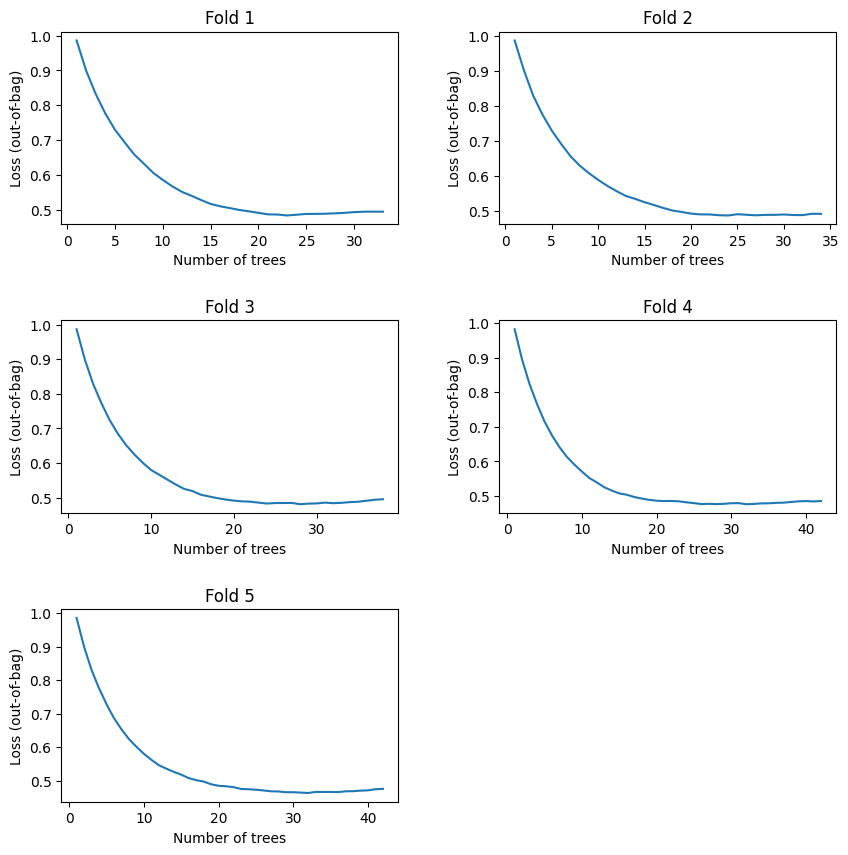

In [16]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

In [17]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.8172 loss: 0.4994
fold_2: acc: 0.8318 loss: 0.4474
fold_3: acc: 0.8128 loss: 0.4746
fold_4: acc: 0.8153 loss: 0.5143
fold_5: acc: 0.8223 loss: 0.4717

Average accuracy: 0.8199  Average loss: 0.4815


In [18]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model_rf = build_model(best_hps[0])



Use /tmp/tmptvdh_q9h as temporary training directory


[WARNING 24-01-04 09:36:17.7555 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:36:17.7555 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-04 09:36:17.7555 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


## TRAINING ON FULL TRAINING DATASET

In [19]:
X_train, X_test = train_test_split(train_df, test_size=0.33,
                                   
                                  stratify= train_df["Status"])



print(X_train.shape)
print(X_test.shape)

(5296, 29)
(2609, 29)


In [20]:
# define the target column and create TensorFlow datasets
target = "Status"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=target, task=tfdf.keras.Task.CLASSIFICATION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=target, task=tfdf.keras.Task.CLASSIFICATION)

In [21]:
model_rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.726013. Found 5296 examples.
Training model...


[INFO 24-01-04 09:36:32.8497 UTC kernel.cc:1243] Loading model from path /tmp/tmptvdh_q9h/model/ with prefix b5123fbed77d47ee


Model trained in 0:00:14.451530
Compiling model...


[INFO 24-01-04 09:36:33.0685 UTC decision_forest.cc:660] Model loaded with 93 root(s), 49125 node(s), and 28 input feature(s).
[INFO 24-01-04 09:36:33.0685 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-04 09:36:33.0686 UTC kernel.cc:1075] Use fast generic engine


Model compiled.


In [22]:
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=4)

In [23]:
model_rf.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("Bilirubin" (1; #5), 40.0),
  ("N_Days" (1; #15), 10.0),
  ("Cholesterol" (1; #6), 9.0),
  ("Age" (1; #0), 7.0),
  ("Alk_Phos" (1; #2), 6.0),
  ("Copper" (1; #7), 6.0),
  ("Stage_4" (1; #26), 5.0),
  ("Prothrombin" (1; #17), 3.0),
  ("Albumin" (1; #1), 2.0),
  ("Hepatomegaly_N" (1; #13), 2.0),
  ("Edema_N" (1; #10), 1.0),
  ("Platelets" (1; #16), 1.0),
  ("Sex_F" (1; #19), 1.0)],
 'NUM_NODES': [("N_Days" (1; #15), 2493.0),
  ("Copper" (1; #7), 2284.0),
  ("Age" (1; #0), 2250.0),
  ("Platelets" (1; #16), 2214.0),
  ("Albumin" (1; #1), 2097.0),
  ("Alk_Phos" (1; #2), 2093.0),
  ("SGOT" (1; #18), 2034.0),
  ("Bilirubin" (1; #5), 1988.0),
  ("Cholesterol" (1; #6), 1892.0),
  ("Tryglicerides" (1; #27), 1694.0),
  ("Prothrombin" (1; #17), 1635.0),
  ("Stage_4" (1; #26), 351.0),
  ("Stage_3" (1; #25), 255.0),
  ("Hepatomegaly_N" (1; #13), 172.0),
  ("Hepatomegaly_Y" (1; #14), 170.0),
  ("Drug_D-penicillamine" (1; #8), 153.0),
  ("Drug_Placebo" (1; #9), 149.0),
  ("Spiders_N"

## MODEL EVALUATION

In [24]:
evaluation = model_rf.evaluate(test_ds, return_dict=True)

print(evaluation)

3/3 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 0.8229 - sparse_categorical_crossentropy: 0.4795
{'loss': 0.0, 'accuracy': 0.8229206800460815, 'sparse_categorical_crossentropy': 0.4795069396495819}


# PREDICTIONS

In [27]:
TEST_PATH = "/kaggle/input/playground-series-s3e26/test.csv"

test_df = pd.read_csv(TEST_PATH)

print(test_df.shape)
test_df.head()

(5271, 19)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [28]:
test_df['Stage'] = test_df['Stage'].astype(int).astype("O")

cat_cols = ['Drug',  'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Stage']

test_df = pd.concat([test_df, pd.get_dummies(test_df[cat_cols], dtype=int)], axis = 1)
test_df.drop(cat_cols, axis = 1 , inplace = True)
test_df.head()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1,Stage_2,Stage_3,Stage_4
0,7905,3839,19724,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,...,1,1,0,1,0,0,0,1,0,0
1,7906,2468,14975,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,...,0,1,0,1,0,0,0,1,0,0
2,7907,51,13149,2.0,151.0,2.96,46.0,961.0,69.75,101.0,...,1,1,0,0,0,1,0,0,0,1
3,7908,2330,20510,0.6,293.0,3.85,40.0,554.0,125.55,56.0,...,0,1,0,1,0,0,0,1,0,0
4,7909,1615,21904,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,...,1,1,0,1,0,0,1,0,0,0


In [29]:
cols = X_train.columns.drop("Status")
test_df = test_df[cols]

test_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1,Stage_2,Stage_3,Stage_4
0,3839,19724,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,...,1,1,0,1,0,0,0,1,0,0
1,2468,14975,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,...,0,1,0,1,0,0,0,1,0,0
2,51,13149,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,...,1,1,0,0,0,1,0,0,0,1
3,2330,20510,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,...,0,1,0,1,0,0,0,1,0,0
4,1615,21904,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,...,1,1,0,1,0,0,1,0,0,0


In [30]:
X_test = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

In [31]:
ypred = model_rf.predict(X_test)
ypred = pd.DataFrame(ypred, columns = classes)
ypred = ypred.add_prefix("Status_")
ypred

6/6 [==============================] - 0s 20ms/step


,Status_D,Status_C,Status_CL
0,0.897541,0.022469,0.079990
1,0.738080,0.051693,0.210227
2,0.060089,0.041720,0.898192
3,0.961214,0.014871,0.023915
4,0.802099,0.031191,0.166710
...,...,...,...
5266,0.844899,0.071323,0.083778
5267,0.960726,0.023293,0.015981
5268,0.961067,0.012847,0.026086
5269,0.984346,0.008851,0.006803


In [32]:
SUB_PATH = "/kaggle/input/playground-series-s3e26/sample_submission.csv"

submission = pd.read_csv(SUB_PATH)

print(submission.shape)
submission.head()

(5271, 4)


,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


In [33]:
for col in ypred.columns:
    submission[col] = ypred[col]

In [34]:
submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.022469,0.079990,0.897541
1,7906,0.051693,0.210227,0.738080
2,7907,0.041720,0.898192,0.060089
3,7908,0.014871,0.023915,0.961214
4,7909,0.031191,0.166710,0.802099


In [35]:
submission.to_csv("cirrhosis_sub.csv", index = False)